Here I implement gradient descent on NLLS in a problem to estimate parameters for expansion of copper as a function of temperature using a real dataset. 

In NLLS, we wish to fit a model of the form,

     yhat = g(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  We find `w` by minimizing a least-squares function 

     f(w) = \sum_i (y_i - g(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  This is similar to linear least-squares, but the function `g(x,w)` may not be linear in `w`.  In general, this optimization has no closed-form expression.  So numerical optimization must be used.  



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

I use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

In [ ]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['x0','y0','dummy'])
df.head()

,x0,y0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


In [ ]:
df['x0']

0       0.591
1       1.547
2       2.902
3       2.894
4       4.703
        ...  
231    21.035
232    20.930
233    21.074
234    21.085
235    20.935
Name: x0, Length: 236, dtype: float64

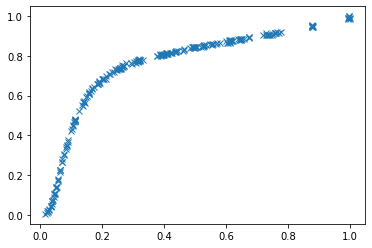

In [ ]:
x0 = df['x0'].values
y0 = df['y0'].values
x = x0/np.max(x0)
y = y0/np.max(y0)
plt.plot(y, x, 'x')
plt.show()

To make the problem a little more challenging, I added some random Gaussian noise with mean 0 and std. dev = 0.05 to `y`.  

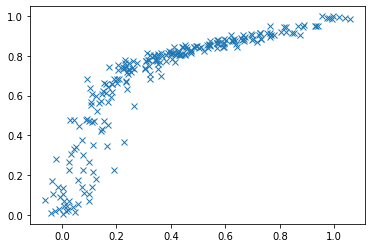

In [ ]:
yn = y + np.random.normal(0, 0.05, y.shape)
plt.plot(yn, x, 'x')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
xtr, xts, ytr, yts = train_test_split(x, yn, test_size=0.33)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.  
   

In [ ]:
def predict(w,x):
    
  # Get the length
  d = (len(w)-1)//2

  # Extract a and b from w
  a = w[ : d + 1]
  b = w[d + 1 : ]
  b = np.append([1], b)

  # Compute yhat
  yhat = np.polynomial.polynomial.polyval(x, a)/np.polynomial.polynomial.polyval(x, b)
  return yhat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ] 

In [ ]:
d = 3

# Ttransformed feature matrix
indices = np.arange(d) + 1
x_d = np.power(xtr[:, None], indices)
Z = np.hstack((x_d, - x_d * ytr[:, None]))

# Fit with parameters with linear regression
regr = LinearRegression()
regr.fit(Z, ytr)

# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
winit = np.append(regr.intercept_, regr.coef_)
print(winit)

[ 6.42328618e-03  9.60222319e-02 -5.65047014e-01  5.31842473e-01
 -5.64824698e+00  8.50391100e+00 -3.79766436e+00]


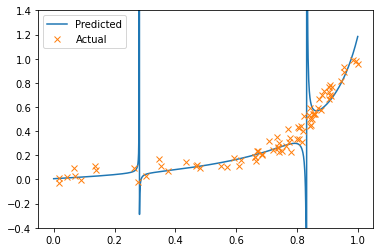

In [ ]:
xp = np.arange(0, 1, 0.001)
yhat = predict(winit, xp)
plt.plot(xp, yhat)
plt.plot(xts, yts, 'x')
plt.legend(['Predicted', 'Actual'])
plt.ylim([-0.4, 1.4])
plt.show()

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, I used Ridge regression, to try to keep the parameters close to zero.  

In [ ]:
# Fit with parameters with linear regression
regr = Ridge(alpha=1e-3)
regr.fit(Z, ytr)

# Extract the parameters from regr.coef_ and regr.intercept_
winit = np.append(regr.intercept_, regr.coef_)
print(winit)

[ 2.17396716e-03  2.33288338e-01 -5.22679404e-01  2.59967941e-01
 -2.47234929e+00  1.58435954e+00 -1.28059581e-01]


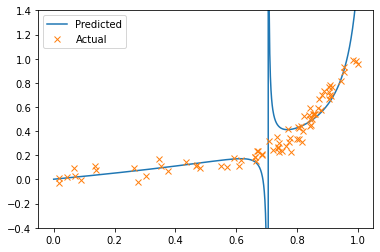

In [ ]:
yhat = predict(winit, xp)
plt.plot(xp, yhat)
plt.plot(xts, yts, 'x')
plt.legend(['Predicted', 'Actual'])
plt.ylim([-0.4, 1.4])
plt.show()

## Creating a Loss Function

I then used gradient descent to improve initial estimate.  

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    


In [ ]:
def feval(w,x,y): 
  # Parse w
  d = (len(w)-1)//2
  a = w[ : d + 1]
  btemp = w[d + 1 : ]
  b = np.append([1], btemp)

  # Znum[i,j] = x[i]**j
  Znum = np.power(x[:, None], np.arange(d + 1))

  # Zden[i,j] = x[i]**(j+1)
  Zden = np.power(x[:, None], np.arange(d + 1))

  # Compute yhat 
  yhat = np.sum(Znum * a, axis=1)/np.sum(Zden * b, axis=1)

  # Compute loss
  f = 0.5 * np.sum((y - yhat)**2)

  # Compute gradients
  fgrada = np.sum(Znum * ((yhat - y)/ np.sum(Zden * b, axis=1))[:, None], axis=0)
  fgradb = np.sum(Zden[:, 1:] * ((y - yhat) * yhat/np.sum(Zden * b, axis=1))[:, None], axis=0)

  fgrad = np.hstack((fgrada, fgradb))

  return f, fgrad

In [ ]:
w0 = np.copy(winit)
f0, fgrad0 = feval(w0, xtr, ytr)

# w1 very close to w0
w1 = np.copy(w0)
w1 *= 1.0001

f1, fgrad1 = feval(w1, xtr, ytr)

# Verify that f1-f0 is close to the predicted value based on the gradient
print("f1 - f0: ", f1 - f0)
print("Predicted: ", np.dot(fgrad0, (w1 - w0)))

f1 - f0:  -0.031700717575245285
Predicted:  -0.040210285265703395


## Minimizing the loss function with gradient descent

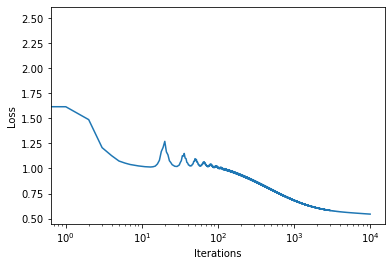

In [ ]:
nit = 10000
step = 1e-6
w0 = np.copy(winit)
fgd = []
for i in range(nit):
  f0, fgrad0 = feval(w0, xtr, ytr)
  w0 = w0 - step*fgrad0
  fgd.append(f0)
plt.semilogx(fgd)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

Loss function has decreased, but still hasnt converged after 1000 iterations

For faster convergence implemented adaptive step-size using the Armijo rule. 

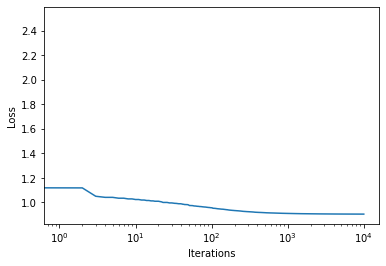

In [ ]:
nit = 10000
step = 1e-6  # Initial step

w0 = np.copy(winit)
fadapt = []
f0, fgrad0 = feval(w0, xtr, ytr)

for i in range(nit):

  w1 = w0 - step*fgrad0
  f1, fgrad1 = feval(w1, xtr, ytr)

  # Check if test point passes Armijo role
  df_est = fgrad0.dot(w1 - w0)
  alpha = 0.5
  if (f1-f0 < alpha * df_est) and (f1 < f0):
    # if descent sufficient, increase learning rate 
    step = step*2
    f0 = f1
    fgrad0 = fgrad1
    w0 = w1
  else:
    # else, decrease
    step = step/2       
      
  fadapt.append(f0)
  
plt.semilogx(fadapt)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

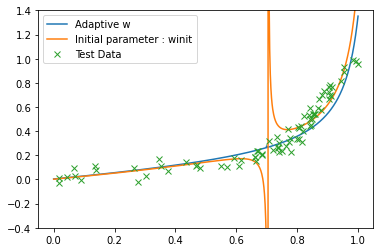

In [ ]:
xp = np.linspace(0, 1, 1000)
yhat = predict(w0, xp)

yhat_init = predict(winit, xp)

plt.plot(xp, yhat)
plt.plot(xp, yhat_init )
plt.plot(xts, yts, 'x')
plt.legend(['Adaptive w', 'Initial parameter : winit', 'Test Data'])
plt.ylim(-0.4, 1.4)
plt.show()

## Momentum Gradient Descent

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient. 

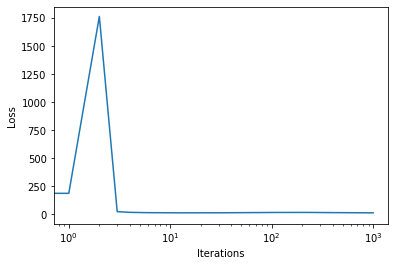

In [ ]:
nit = 1000
step = 1e-5
beta = 0.99

w0 = np.copy(winit)
z = np.zeros(w0.shape)
fgd = []
for i in range(nit):
  f0, fgrad0 = feval(w0, xtr, ytr)
  z = beta*z + fgrad0
  w0 = w0 - step*z
  fgd.append(f0)

plt.semilogx(fgd)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

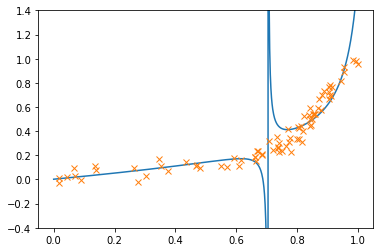

In [ ]:
xp = np.linspace(0, 1, 1000)
yhat = predict(winit, xp)

plt.plot(xp, yhat)
plt.plot(xts, yts, 'x')
plt.ylim(-0.4, 1.4)
plt.show()